# KMeans

### Import the packages and data 

In [1]:
from IPython.display import Image
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [12, 12]
pd.set_option("precision", 5)

In [36]:
data = pd.read_csv('Data/customer_data.csv')
pca_data = pd.read_csv('Data/pca_customer_data.csv')
#data = table.to_pandas()

In [37]:
data.shape

(810341, 7)

In [38]:
pca_data.shape

(810341, 16)

### Edit PCA df 

In [39]:
pca_data.head(2)

,Unnamed: 0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,UniqueID
0,0,-0.36404,-0.10717,-0.00789,-0.10554,0.09196,-0.06825,0.0391,0.17101,-0.17915,0.14691,0.80468,0.11034,0.69459,-0.16208,57c316839e1dbcd90f5d1bd6eb42d12f
1,1,-0.36560,-0.13389,0.01515,-0.16260,0.24113,-0.05589,-0.1317,0.18636,-0.58668,-0.59495,0.07516,0.54612,0.04684,-0.01282,4d29a19dfe6806f18bce01bb0fe85675


In [40]:
del pca_data["Unnamed: 0"]
pca_data = pca_data.drop(columns="UniqueID")

In [41]:
pca_data.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14
0,-0.36404,-0.10717,-0.00789,-0.10554,0.09196,-0.06825,0.03910,0.17101,-0.17915,0.14691,0.80468,0.11034,0.69459,-0.16208
1,-0.36560,-0.13389,0.01515,-0.16260,0.24113,-0.05589,-0.13170,0.18636,-0.58668,-0.59495,0.07516,0.54612,0.04684,-0.01282
2,-0.36401,-0.05898,0.02148,-0.04153,0.26839,-0.13968,0.77005,0.41539,-0.24586,-0.00061,0.22081,-0.38587,-0.35096,0.76436
3,-0.36489,-0.08467,0.00930,-0.12243,0.06414,-0.05118,0.04338,0.13623,-0.12857,0.08936,0.27436,0.15645,-0.06833,0.02335
4,-0.37239,-0.70735,-0.07343,0.44328,-0.13789,-0.14192,-0.23243,0.57566,0.67778,-0.15119,-0.19604,0.07654,0.07596,-0.00871


### Edit Customer df

In [164]:
#data = data[0:1000]

In [42]:
data.head(2)

,Unnamed: 0,UniqueID,FrequencyofVisits,Age,Sex,Payer,Facility
0,0,57c316839e1dbcd90f5d1bd6eb42d12f,3,37.0,Feminino,FUTURE HEALTHCARE,HCS
1,1,4d29a19dfe6806f18bce01bb0fe85675,13,37.0,Feminino,FUTURE HEALTHCARE,ICDT


In [44]:
del data["Unnamed: 0"]
data = data.drop(columns="UniqueID")

In [45]:
data.head(2)

,FrequencyofVisits,Age,Sex,Payer,Facility
0,3,37.0,Feminino,FUTURE HEALTHCARE,HCS
1,13,37.0,Feminino,FUTURE HEALTHCARE,ICDT


## Working with K-means

### Loading the data 

In [46]:
pca_data.dtypes

PC1     float64
PC2     float64
PC3     float64
PC4     float64
PC5     float64
PC6     float64
PC7     float64
PC8     float64
PC9     float64
PC10    float64
PC11    float64
PC12    float64
PC13    float64
PC14    float64
dtype: object

In [47]:
pca_data.isnull().values.any()

False

### K-means

In [48]:
from sklearn.cluster import KMeans

In [49]:
data_processed= pca_data.dropna()

In [50]:
estimator_kmeans = KMeans(random_state=42, n_clusters=3)
estimator_kmeans.fit(data_processed)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [51]:
cluster_labels = estimator_kmeans.labels_
#cluster_labels

In [52]:
#seperate the data into test and train and use train all the way and use ".predict" for the test

In [53]:
centroids = estimator_kmeans.cluster_centers_

In [54]:
centroids.shape

(3, 14)

In [55]:
estimator_kmeans.inertia_

993707.2778021018

In [56]:
from sklearn.metrics import euclidean_distances

In [57]:
centroid_distances = euclidean_distances(centroids)

In [58]:
centroid_distances.shape

(3, 3)

In [59]:
estimator_kmeans.labels_.shape

(810341,)

In [ ]:
#Add cluster label to both df's
pca_data['cluster_id'] = cluster_labels
data['cluster_id'] = cluster_labels
processed_data['cluster_id'] = cluster_labels

In [65]:
numerical_data = data.select_dtypes(np.number)
categorical_data = data.select_dtypes([object, "category"])

In [66]:
data.head()

,FrequencyofVisits,Age,Sex,Payer,Facility,cluster_id
0,3,37.0,Feminino,FUTURE HEALTHCARE,HCS,1
1,13,37.0,Feminino,FUTURE HEALTHCARE,ICDT,1
2,6,37.0,Feminino,ADVANCECARE,CCB,1
3,6,37.0,Feminino,IASFA,CCMF,1
4,13,37.0,Feminino,ADSE,CCC,0


In [67]:
def cluster_summary(cluster_id):
    cluster = data[data.cluster_id==cluster_id]
    cluster_summary = cluster[categorical_data.columns].mode().to_dict(orient="records")[0]
    cluster_summary.update(cluster.mean().to_dict())
    return cluster_summary

In [72]:
cluster = data[data.cluster_id==2]
cluster[categorical_data.columns].mode().to_dict(orient="records")

[{'Sex': 'Masculino', 'Payer': 'MULTICARE', 'Facility': 'HCD'}]

In [69]:
cluster_summary(1)

{'Sex': 'Feminino',
 'Payer': 'MULTICARE',
 'Facility': 'HCD',
 'FrequencyofVisits': 7.583388741001754,
 'Age': 51.480476898002685,
 'cluster_id': 1.0}

In [84]:
# Distance between centroid of cluster 0 and 2 
centroid_distances[0,2]

1.2436452524992418

In [70]:
def cluster_comparison(*cluster_ids):
    summaries = []
    for cluster_id in cluster_ids:
        summaries.append(cluster_summary(cluster_id))
    return pd.DataFrame(summaries).set_index("cluster_id").T

In [71]:
cluster_comparison(0,1,2)

cluster_id,0.0,1.0,2.0
Age,51.79,51.48,52.358
Facility,HCP,HCD,HCD
FrequencyofVisits,8.1547,7.5834,7.5536
Payer,ADSE,MULTICARE,MULTICARE
Sex,Feminino,Feminino,Masculino


In [73]:
def kmeans_cluster(df, n_clusters=3):
    model = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = model.fit_predict(df)
    cluster_results = df.copy()
    cluster_results['Cluster'] = clusters
    return cluster_results

def graph_summary_clustering(results):
    cluster_size = results.groupby(['Cluster']).size().reset_index()
    cluster_size.columns = ['Cluster', 'Count']
    cluster_means = results.groupby(['Cluster'], as_index=False).mean()
    cluster_summary = pd.merge(cluster_size, cluster_means, on='Cluster')
    cluster_summary = cluster_summary.drop(["Count"], axis=1).set_index("Cluster")
    return cluster_summary[sorted(cluster_summary.columns)]

In [74]:
cluster_results = kmeans_cluster(data_processed, 3)
cluster_summary = graph_summary_clustering(cluster_results);
cluster_summary

,PC1,PC10,PC11,PC12,PC13,PC14,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
Cluster,,,,,,,,,,,,,,
0,-0.00823,-0.02310,-0.05743,-0.05561,0.01197,0.00025,-0.67450,-0.09162,0.51443,-0.13876,-0.04663,-0.08619,-0.06522,0.04114
1,-0.36101,0.00553,0.01371,0.01331,-0.00282,0.00024,0.16504,0.02166,-0.12348,0.03352,0.01078,0.02071,0.01534,-0.00978
2,0.63898,0.00551,0.01376,0.01326,-0.00293,-0.00058,0.15459,0.02232,-0.12211,0.03256,0.01179,0.02043,0.01603,-0.00994


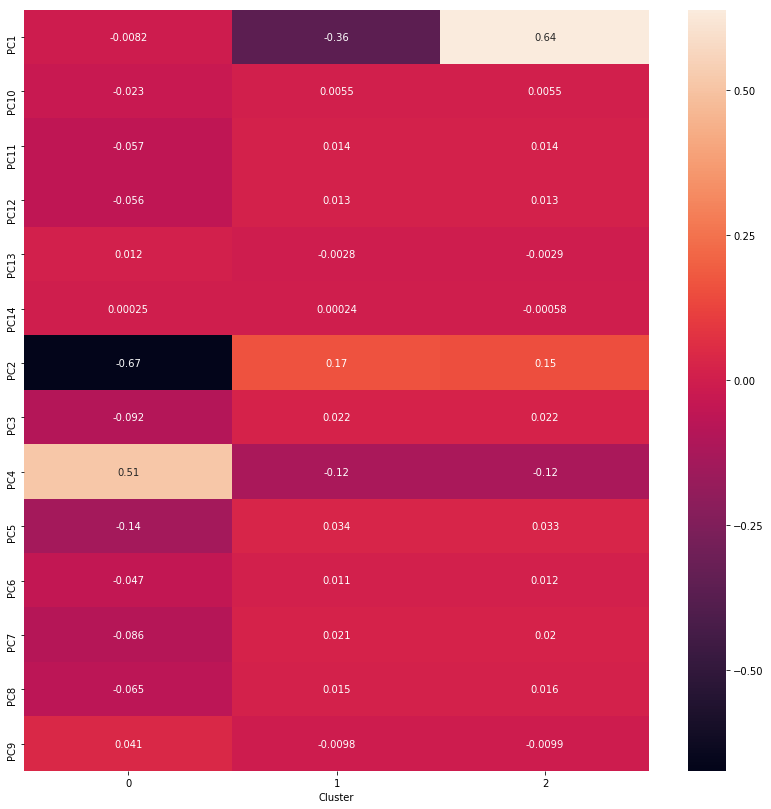

In [75]:
matplotlib.rcParams['figure.figsize'] = [14, 14]
import seaborn as sns
sns.heatmap(cluster_summary.transpose(), annot=True);

### Ideal number of clusters?

In [76]:
from scipy.spatial.distance import cdist

In [77]:
total_variance = cdist(
    XA=data_processed, 
    XB=np.array([data_processed.mean()]))

In [78]:
total_variance_sum = total_variance.sum()

In [79]:
#functions to calculate the Within-Cluster sum of squares (WSS)
def cluster_variance(cluster_id, cluster_centroid, cluster_labels):
    cluster_elements = data_processed[cluster_labels==cluster_id]
    return cdist(XA=cluster_elements, XB=np.array([cluster_centroid])).sum()

#explained variance (defined as the reduction of variance compared to the total variance,...
# ... which would be the variance where k=1).
def variance_measure(estimator_kmeans, total_variance):
    clusters_labels = estimator_kmeans.labels_
    wss = 0
    for i, cluster_id in enumerate(np.unique(clusters_labels)):
        cluster_centroid = estimator_kmeans.cluster_centers_[i]
        wss += cluster_variance(cluster_id, cluster_centroid, clusters_labels)
    return (total_variance-wss) / total_variance

In [80]:
# Function that returns the inertia.
def inertia_measure(estimator_kmeans):
    return estimator_kmeans.inertia_

In [81]:
# Create a function that evaluates the intertia and percentage variance explained for a value of K
def evaluate_k_kmeans(k, scoring, **kwargs):
    scoring_measure = None
    if scoring=="inertia":
        scoring_measure = inertia_measure
    elif scoring=="variance":
        scoring_measure = variance_measure
        
    estimator_kmeans = KMeans(random_state=42, n_clusters=k)
    estimator_kmeans.fit(data_processed)
    return scoring_measure(estimator_kmeans, **kwargs)

In [ ]:
results_k = {}
range_k = [1,2,3,4,5,6,7,8,9] #range_k gives the number of clusters to evaluate their inertia and variance
for k in range_k:
    results_k[k] = (
        evaluate_k_kmeans(k, "inertia"), 
        evaluate_k_kmeans(k, "variance", total_variance=total_variance_sum), 
    )

In [ ]:
fig, ax1 = plt.subplots()

ax1.plot(
    [c[0] for c in results_k.items()],
    [c[1][0] for c in results_k.items()], label="inertia", color="red")
ax1.set_ylabel('inertia', color="red")


ax2 = ax1.twinx()
ax2.plot(
    [c[0] for c in results_k.items()],
    [c[1][1] for c in results_k.items()], label="percentage variance explained", color="blue")
ax2.set_ylabel('percentage variance', color='blue')

plt.xlabel("K")
plt.legend()
plt.title("Percentage variance / Inertia by. K");

In [ ]:
sse = {}
for k in range(1, 10):
   kmeans = KMeans(n_clusters=k).fit(data_processed)
   #print(data["clusters"])
   sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

## Change the number of clusters 

In [ ]:
clusterer = KMeans(n_clusters=6)
clusterer.fit(data_processed)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import silhouette_score

In [190]:
def silhouette_score_cv(clusterer, X, y=None):
    cluster_labels = clusterer.fit_predict(X)
    return silhouette_score(X, cluster_labels)

In [191]:
cross_val_score(clusterer, data_processed, y=None, 
                scoring=silhouette_score_cv, cv=3).mean() #a small value means it is well matched

0.17105614782327164

In [192]:
pd.Series(clusterer.labels_).value_counts()

3    272
2    217
1    217
5    116
0     99
4     79
dtype: int64

In [193]:
new_clusters = clusterer.labels_
data["Cluster"] = new_clusters
data.head()

,FrequencyofVisits,Age,Sex,Payer,Facility,Cluster,cluster_id
0,1,37.0,Feminino,PARTICULARES,CCTV,3,1
1,15,37.0,Feminino,IASFA,CCM,3,1
2,13,37.0,Feminino,MÉDIS,HCD,2,0
3,32,37.0,Feminino,ALLIANZ,CCA,3,1
4,1,37.0,Feminino,ADVANCECARE,CCM,3,1


In [197]:
from sklearn.cluster import MiniBatchKMeans

In [217]:
%%time
estimator_kmeans = KMeans(n_clusters=8).fit(data1)

CPU times: user 47.5 ms, sys: 1.58 ms, total: 49.1 ms
Wall time: 48.1 ms


In [218]:
estimator_kmeans = KMeans(n_clusters=8).fit(data1)

In [219]:
cluster_labels = estimator_kmeans.labels_

In [200]:
estimator_kmeans.inertia_

1386.3767842926277

MiniBatchKMeans is faster and has a higher inertia.

## Internal Evaluation metrics

In [204]:
from IPython.display import Image
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")

%matplotlib inline

In [194]:
from sklearn.cluster import MiniBatchKMeans

In [213]:
data1=data[["FrequencyofVisits","Age"]]

In [222]:
data1.head()

,FrequencyofVisits,Age
0,1,37.0
1,15,37.0
2,13,37.0
3,32,37.0
4,1,37.0


In [224]:
silhouette_score(data1, cluster_labels)

0.45110692630357624